<a href="https://colab.research.google.com/github/JLundsberg/Tutorial/blob/main/Tutorial_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Decomposition of EMG
## Background
Electromyography (EMG) is the recording of electrical activity of muscles specifically. Muscles are made up of individual motor units which are each controlled by a motor neuron. The motor neuron relays action potentials to all muscle fibers in a motor unit. Hundreds of fibers can make up a motor unit, depending on the muscle. The action potential continues throughout the fibers, generally from the center to the tendons on both ends. Since there are so many fibers in one motor unit, each action potential is amplified, to the point where they can be recorded on the skin surface. 

Recording and analyzing motor units is important in several areas. In neurology, insight to diseases can be gained since the motor units are directly connected to the nervous system. For prosthetic control, better understanding of the EMG signal is important to create a more natural way of controlling, for example,a prosthetic hand. This tutorial stems from a project focused on rehabilitation. Our aim is to track the recovery of motor units in stroke patients over time. This would provide valuable data for improving the progression of rehabilitation of patients who've lost motor control.

A recording on the skin, surface EMG (sEMG), picks up a noisy mix of many motor units at once, due to the distance to the muscle at the skin surface. In contrast, an intramuscluar recording (iEMG) is far more local. Individual units and action potential firings are more easily discerned. But invasive recordings, such as iEMG, bring several complications. There is risk of infection, damage to the muscle, and it may be nausiating or uncomfortable for the subject. By using sEMG, we avoid the issues of iEMG, but we need to solve a more complicated signal separation problem instead.

## Decomposition
The purpose of decomposition is to separate mixed signals into the underlying sources. In this tutorial we will use Independent Component Analysis (ICA), which will briefly be summarized later. ICA requires a large number of simultaneous observations. We have a dataset of simultaneous iEMG and high-density sEMG (HD-sEMG). The HD-sEMG contains an array of 64 electrodes (8-by-8). Using ICA, we will estimate sources from the HD-sEMG data, and compare them to the iEMG signal.


## Practical issues
This tutorial is meant to be run on Googles colab. 

#### Import
Numpy and scipy are used to handle the data, and matplotlib to plot the data and the results.

In [1]:
import numpy as np
import scipy.io as scp
import matplotlib.pyplot as plt

Upload both data files for iEMG and sEMG. If you are using Google Colab you can use the below-mentioned commands. If you are using a local version of Python and/or Jupyter notebooks and have the the datafiles in the same folder you can skip the following step

In [ ]:
from google.colab import files
file = files.upload()

## Data
This recording was done on the flexor digitorum profundus. A muscle on the medial side of the forearm, which flexes the fingers. The iEMG was recorded with a wire electrode inside the muscle. The HD-sEMG array was placed on top, covering almost a square decimeter of the skin. The files contain 25 seconds data, at 2048 samples per second, extracted from a larger set. The frequency range of interest for sEMG is in the 5-500 Hz range. A lot of noise is removed just by filtering the data. iEMG is commonly low-pass filtered at 1 kHz, but for the sake of simplicity, both files are pre-filtered with a bandpass filter at 5-500 Hz.

An additional method of reducing noise is to use a differential setup. In a differential setup, each electrode measures the difference to the next neighbour, instead of using a single reference electrode. This has a large impact on noise but also changes the signal itself. It also means we end up with 63 observations instead of 64, since the last electrode has no next neighbour.


In [2]:
samplerate = 2048
sEMG = scp.loadmat('sEMGx64_filtered_2048_303to328.mat')['sData'].T
iEMG = scp.loadmat('iEMG_filtered_2048_303to328.mat')['iData']
Time = np.arange(303, 328, 1/samplerate)

# Plot surface EMG
We start off by comparing the different signals. An example electrode of sEMG is chosen below. Start and End values determine the window of the plot, which can't exceed 303-328 seconds (the real time of the recording). Test by plotting different channels by changing electrode (acceptable values are between 0-62). Note the general qualities of the signal, i.e. the noise level, how are spikes distributed, do they vary a lot?

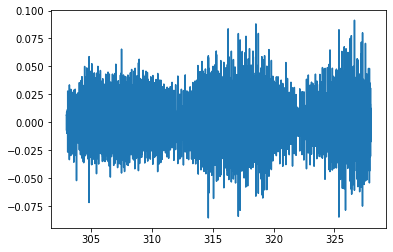

In [4]:
Electrode = 33 # Test by selecting different EMG channels/electrodes
Start = 303
End = 328

# Plot sEMG in the selected window
TimeS = np.arange(int((Start-303)*samplerate), int((End-303)*samplerate))
plt.figure()
plt.plot(Time[TimeS], sEMG[Electrode, TimeS])
plt.show()

# Plot intramuscular EMG
Plot the iEMG and compare the qualities to sEMG. Select a smaller window (start and end points) to see distinct spikes.

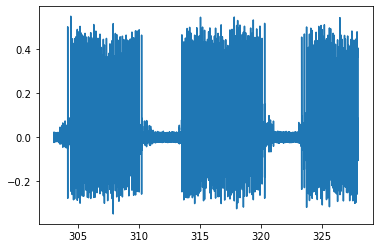

In [9]:
Start = 303
End = 328

# Plot iEMG in the selected window
TimeS = np.arange(int((Start-303)*samplerate), int((End-303)*samplerate))
plt.figure()
plt.plot(Time[TimeS], iEMG[TimeS])
plt.show()

# Independent Component Analysis
ICA is a signal separation technique which works for many types of mixed signals where there are multiple observations. At each observation (in our case every electrode) the contribution of the underlying sources differ. This difference is what makes ICA work. The algorithm itself is an iterative search which continously updates a de-mixing matrix. The algorithm estimates the sources, and moves in the direction which maximizes statistical independence. It iterates until it convergences at a tolerance level or reaches a maximum number of iterations.

This ICA algorithm estimates a pre-determined number of sources at once. The entire function is included below. The last line of the block calls the function, which is the 'run_ica()' command. Try different numbers of sources as input (between 1-10 are good values). Note the differences in speed. You will see the iteration count, followed by a delta value. The delta value signifies the difference to the previous iteration to determine if the algorithm has converged. The algorithm uses a random starting point which means you may or may not get the same sources each time you run the algorithm.

In [10]:
def run_ica(x, samplerate, sources, gradient_type, extension):

    ########################## Constants
    ##### Convergence tolerance
    tolerance = 1e-6
    ##### Maximum iterations
    iterations = 500
    ##### Data points
    n = np.size(x, 1)

    ########################## Extension & Demixing matrix
    if 'extension' in locals() and extension > 1:
        print('Extending data..')
        ##### Sample gap
        gap = int(samplerate/np.power(2, 9))
        ##### Extension
        x_extended = x.copy()
        for i in range(extension-1):
            padding = np.zeros((np.size(x, 0), gap*(i+1)))
            x_padded = np.hstack((padding, x[:, 0:-gap*(i+1)]))
            x_extended = np.vstack((x_extended, x_padded))
        x = x_extended

        ##### Initialize W extended
        w = np.random.rand(sources, np.size(x, 0))
    else:
        ##### Initialize W
        w = np.random.rand(sources, np.size(x, 0))
    ##### Normalize W
    w = w/np.sqrt(np.sum(np.power(w, 2), axis=1, keepdims=True))

    ########################## Centering and whitening
    print('Whitening data..')
    ##### Centering rows
    x_mean = x.mean(1, keepdims=True)
    x_centered = x-x_mean
    ##### Whitening
    r_cov = np.cov(x_centered)
    u_cov, s_cov, v_cov = np.linalg.svd(r_cov, hermitian=True)
    v = u_cov @ (np.diag(1/np.sqrt(s_cov)) @ u_cov.T)
    z = v @ x_centered

    ########################## ICA loop
    if 'gradient_type' not in locals():
        gradient_type = 'negentropy'
    print('ICA loop..')
    for i in range(iterations):
        ##### Previous W
        wlast = w.copy()
        ##### Current source estimate
        y = w @ z

        if gradient_type == 'negentropy':
            ##### Gradient function
            g = y*np.exp(-0.5*np.power(y, 2))
            dg = (1-np.power(y, 2))*np.exp(-0.5*np.power(y, 2))

            ##### Update W
            w = (g @ z.transpose())/n - dg.mean(axis=1, keepdims=True)*w
            ##### Normalize W
            w = w/np.sqrt(np.sum(np.power(w, 2), axis=1, keepdims=True))
            ##### Decorrelate W
            u_w, s_w, v_w = np.linalg.svd(w)
            w = u_w @ np.diag(1/s_w) @ u_w.T @ w
        else:
            print('No gradient type')
            return

        ##### Check convergence
        delta = np.max(1-np.abs(np.sum(w*wlast, axis=1)))
        if np.mod(i, 50) == 0:
            print(i, '=>', delta)
        if delta < tolerance:
            y = w @ z
            print(i, '=>', delta)
            print('Converged.')
            return y, w, v, x_mean

    ########################## Output
    y = w @ z
    print('Did not converge.')
    return y, w, v, x_mean


##### Call run_ica function
ICs, w, v, mu = run_ica(sEMG, samplerate, sources=5, gradient_type='negentropy', extension=1)

Whitening data..
ICA loop..
0 => 0.6054672007347597
47 => 8.938167340710734e-07
Converged.


# Plot ICA sources
The output sources of ICA can only be estimated down to a scaling factor and the sign. The sources are therefore always normalized. It is an inherent limitation of the method. Artifacts in the data are also picked up by the algorithm as independent sources. This can be bothersome but also useful if you want to somehow remove them from your data.

It's important to understand that the basic ICA model is a rough estimation of actual muscle activity. It is not complex enough to fully estimate the motor units due to their cylindrical shape. The the action potentials move through the fibers, and in two directions. As a result the signal changes somewhat over time. It is therefore likely, that you end up with multiples of a source that infact correspond to different instances in time.



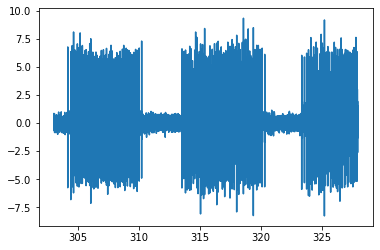

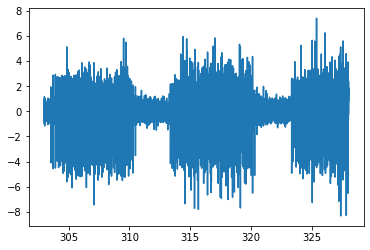

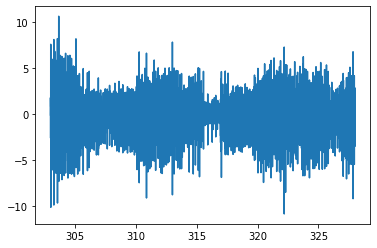

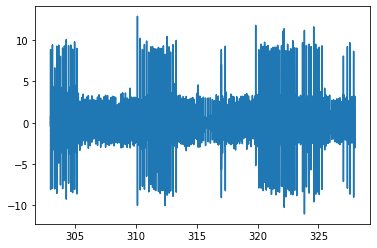

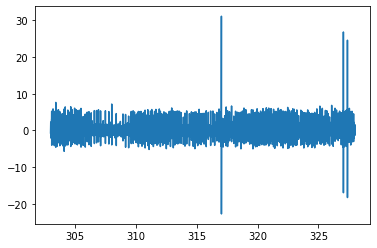

In [11]:
Start = 303
End = 328

# Plot sources in the selected window
TimeS = np.arange(int((Start-303)*samplerate), int((End-303)*samplerate))
for i in range(np.size(ICs, 0)):
    plt.figure()
    plt.plot(Time[TimeS], ICs[i, TimeS])
plt.show()

# Compare spikes from ICA and iEMG
Plot the recorded iEMG on top of the extracted sources below and try to find a source which matches the iEMG. Focus on the time instance of the spikes. If you can't find a source with consistently matching spikes, you can run the algorithm again for a new estimation of sources, or increase the number of sources estimated.

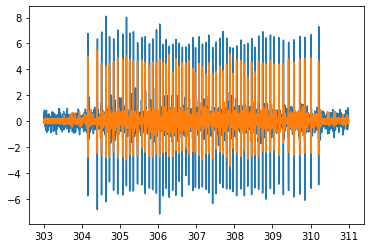

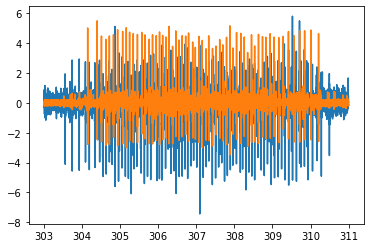

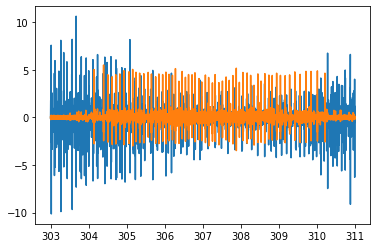

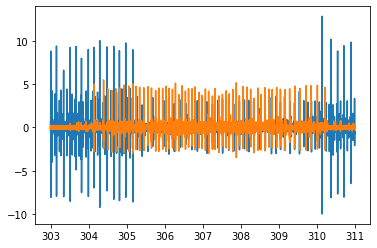

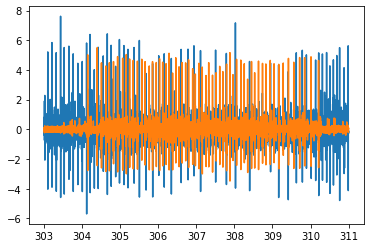

In [12]:
Start = 303
End = 311

# Plot sources and iEMG in the selected window
TimeS = np.arange(int((Start-303)*samplerate), int((End-303)*samplerate))
for i in range(np.size(ICs, 0)):
    plt.figure()
    plt.plot(Time[TimeS], ICs[i, TimeS])
    plt.plot(Time[TimeS], iEMG[TimeS]*10)
plt.show()